# ENSAE / OpenClassrooms - Data Analyst

## Project n°9 - Predict electricity demand

#### Librairies import

In [1]:
import dill
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from multiprocessing import cpu_count

from joblib import Parallel
from joblib import delayed

from descstats import MyPlot, Univa
from modelstats import linear_regression_analysis

import warnings
warnings.filterwarnings("ignore")

def save(name):
    with open(f"data/{name.__name__}.pkl", "wb") as f:
        my_p = dill.Pickler(f)
        my_p.dump(name)
        
def load(name):
    with open(f"data/{name}.pkl", "rb") as f:
        my_unp = dill.Unpickler(f)
        name = my_unp.load()
        return name

## 1. Consumption

#### Data import

Data Source: https://www.rte-france.com/fr/eco2mix/eco2mix-telechargement

In [2]:
df = pd.read_csv(
        "data/consommation.csv",
        parse_dates=[0],
        sep=";",
        names=["mois", "pays", "consommation"],
        index_col="mois")

#### Data clean

I just drop the country, which is only "France".

In [3]:
df.drop('pays', axis=1, inplace=True)

#### Data Overview

I plot the time series about the electricityu consumption.

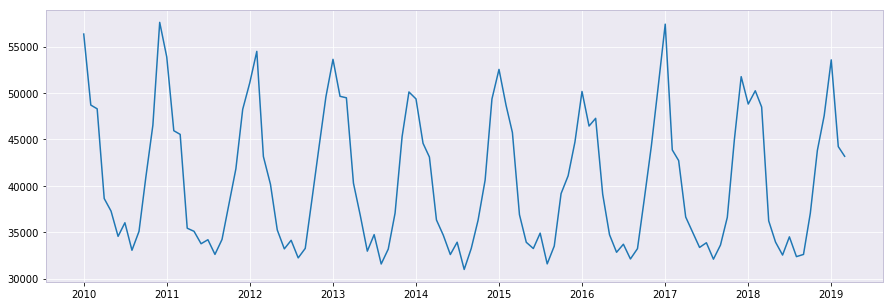

In [4]:
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(df)
MyPlot.bg(ax)
MyPlot.border(ax)
plt.show()

---

## 2. Degrés Jours Unifiés - Paris

DJU are a measure based on a base temperature (generally 18°) for a certain region. The idea is to know for each day, what is the temperature and how much it is far from the base temperature. Generally, we add up on a certain period (month, quarter...).

#### Data import

Source: https://cegibat.grdf.fr/simulateur/calcul-dju

In [5]:
df2 = pd.read_csv("data/dju.csv", index_col="Year")

In [6]:
df2

,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2009,486.8,365.7,293.2,135.1,82.2,39.8,3.1,0.9,26.9,149.6,224.7,411.8
2010,499.2,371.4,294.5,165.3,140.9,22.6,0.0,11.1,52.3,172.2,310.0,512.0
2011,392.0,304.8,243.1,77.6,43.4,31.4,15.0,11.9,23.2,127.6,226.6,312.7
2012,336.0,435.9,201.9,230.3,83.3,35.0,12.4,2.4,58.0,154.6,296.2,345.9
2013,429.2,402.2,376.6,209.5,158.4,43.6,0.6,5.0,41.5,105.0,303.9,349.5
2014,324.4,281.9,223.9,135.5,100.2,19.1,8.3,19.3,16.0,92.3,222.6,368.2
2015,392.0,365.7,275.5,141.1,91.5,15.8,6.9,6.1,71.9,176.9,195.0,248.1
2016,364.4,321.6,321.1,212.1,88.1,27.5,5.7,3.2,11.7,176.0,285.6,390.8
2017,467.9,278.4,206.1,182.6,75.0,9.4,1.0,6.8,62.6,99.4,282.6,369.0


#### From a matrice to a unique column

In [7]:
dju = {
    'mois':[],
    'dju':[]
}

# Parse the dataframe and create a new one column based dataframe
for year in df2.index.values:
    for month in df2.columns:
        dju['mois'].append(f"{year}-{month}-01")
        dju['dju'].append(df2.loc[year, month])
        
dju = pd.DataFrame(dju)
dju['mois'] = pd.to_datetime(dju['mois'])

#### Data merge

In [8]:
df3 = df.merge(dju, how="left", left_index=True, right_on="mois")
df3.set_index('mois', inplace=True)
df3.fillna(0, inplace=True)

In [9]:
df3.head(12)

,consommation,dju
mois,,
2010-01-01,56342,499.2
2010-02-01,48698,371.4
2010-03-01,48294,294.5
2010-04-01,38637,165.3
2010-05-01,37284,140.9
2010-06-01,34567,22.6
2010-07-01,36031,0.0
2010-08-01,33069,11.1
2010-09-01,35104,52.3


#### We keep the data until 2017 december

In [10]:
df4 = df3[df3.index.year < 2018].copy()

## 3. Time series correction - Temperature effect

To plot the autocorrelogram function and the partial autocorrelogram function, I use the methods from statsmodels.graphics.tsaplots

I create a wrapper to get a result more readable and prettier

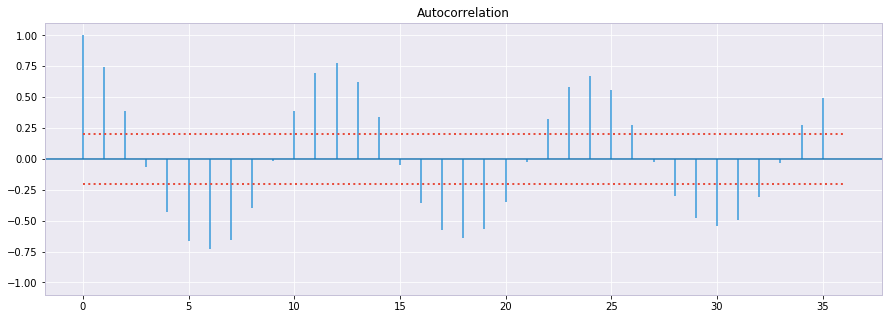

In [11]:
def acf(data, lag, partial=False):
    fig, ax = plt.subplots(figsize=(15,5))
    
    # Styles
    ax.set_facecolor('#ebe9f2')
    ax.grid(color='#FFFFFF', linestyle='-')
    
    for spine in ax.spines.values():
        spine.set_edgecolor('#c6c1d8')
        spine.set_linewidth(1)
    
    vlines_kwargs = {
        'color': '#3498db',
    }
    
    alpha=None
    marker=None

    if partial:
        plot_pacf(data, marker=marker, alpha=alpha, lags=np.arange(lag), ax=ax, vlines_kwargs=vlines_kwargs)
    else:
        plot_acf(data, marker=marker, alpha=alpha, lags=np.arange(lag), ax=ax, vlines_kwargs=vlines_kwargs)
        
    plt.plot((0,lag), (0.2,0.2), color="#e74c3c", linestyle=":", linewidth=2)
    plt.plot((0,lag), (-0.2,-0.2), color="#e74c3c", linestyle=":", linewidth=2)

    plt.ylim((-1.1,1.1))
    plt.show()
    
acf(df4['consommation'], 36)

#### A. "month" feature 

In [12]:
df4['month'] = df4.index.month

#### One Hot Encoding

Each column values becomes a new column with "1" or "0". To do that, I use OneHotEncoder from sklearn.preprocessing.

In [13]:
# From a column to a 2 dimensions ndarray (n rows, 1 column)
months = df4['month'].values.reshape(-1,1)

# Create a new instance from OneHotEncoder fitted on "month"
onehotencoder = OneHotEncoder(categories="auto", sparse=False).fit(months)

# Get the name of each new column
columns = onehotencoder.categories_[0]

# Values
values = onehotencoder.transform(months)

# Datframe
onehot = pd.DataFrame(values, columns=columns, index=df4.index)

# Merging
df5 = df4.merge(onehot, how="left", left_index=True, right_index=True)

# I don't need the 'month' feature anymore, so I drop it.
df5.drop('month', axis=1, inplace=True)

In [14]:
df5.head(12)

,consommation,dju,1,2,3,4,5,6,7,8,9,10,11,12
mois,,,,,,,,,,,,,,
2010-01-01,56342,499.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-02-01,48698,371.4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-03-01,48294,294.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-04-01,38637,165.3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-05-01,37284,140.9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-06-01,34567,22.6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-07-01,36031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2010-08-01,33069,11.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2010-09-01,35104,52.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


#### B. "time" feature

I need a feature to materialize the time flying. So I just created a column with a value from 1 to n

In [15]:
df5['time'] = np.arange(1,len(df5)+1)

In [16]:
df5.head()

,consommation,dju,1,2,3,4,5,6,7,8,9,10,11,12,time
mois,,,,,,,,,,,,,,,
2010-01-01,56342,499.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2010-02-01,48698,371.4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2010-03-01,48294,294.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2010-04-01,38637,165.3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2010-05-01,37284,140.9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


#### LInear regression

I do a linear regression, based on: DJU, Time and months

In [17]:
X = df5.iloc[:,1:]
y = df5.iloc[:,0]
reg_ols1 = sm.OLS(endog = y, exog= X, hasconst=False).fit()
reg_ols1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           consommation   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.551e+04
Date:                Sun, 16 Jun 2019   Prob (F-statistic):          4.84e-134
Time:                        18:47:39   Log-Likelihood:                -777.75
No. Observations:                  96   AIC:                             1583.
Df Residuals:                      82   BIC:                             1619.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
dju           40.6220      2.122     19.147      0.000      36.401      44.843
1           3.731e+04    933.437     39.971      0.000    3.55e+04    3.92e+04
2           3.432e+04    825.807     41.553      0.000    3.27e+04     3.6e+04
3           3.535e+04    680.243     51.961      0.000     3.4e+04    3.67e+04
4           3.164e+04    510.677     61.958      0.000    3.06e+04    3.27e+04
5           3.198e+04    411.111     77.794      0.000    3.12e+04    3.28e+04
6           3.289e+04    350.769     93.764      0.000    3.22e+04    3.36e+04
7           3.481e+04    345.499    100.739      0.000    3.41e+04    3.55e+04
8           3.234e+04    347.508     93.058      0.000    3.16e+04     3.3e+04
9           3.261e+04    364.905     89.360      0.000    3.19e+04    3.33e+04
10           3.32e+04    471.683     70.390      0.000    3.23e+04    3.41e+04
11           3.35e+04    684.929     48.905      0.000    3.21e+04    3.49e+04
12          3.623e+04    868.815     41.695      0.000    3.45e+04     3.8e+04
time         -12.4987      3.244     -3.852      0.000     -18.953      -6.045
==============================================================================
Omnibus:                        8.433   Durbin-Watson:                   1.636
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                8.057
Skew:                           0.648   Prob(JB):                       0.0178
Kurtosis:                       3.580   Cond. No.                     4.77e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Analyse of the linear regression with my own method.

[('Lagrande multiplier statistic', 14.69026285569538), ('p-value', 0.32708597719387694), ('f-value', 1.139613301767245), ('f p-value', 0.3391639265254305)]
Shapiro pvalue : 0.028199676424264908


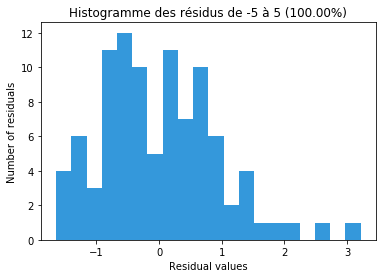

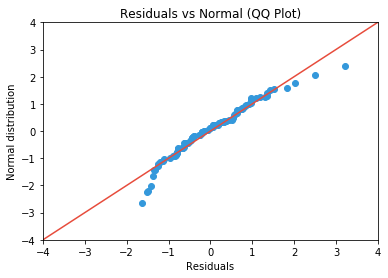

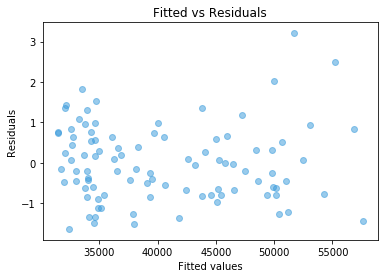

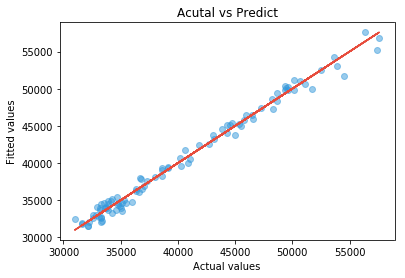

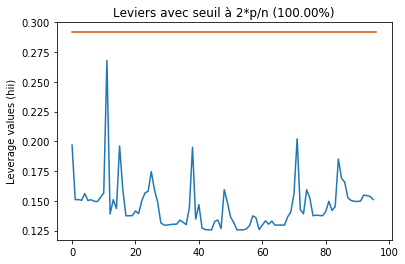

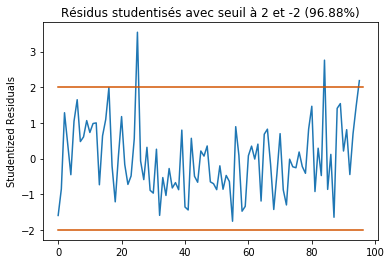

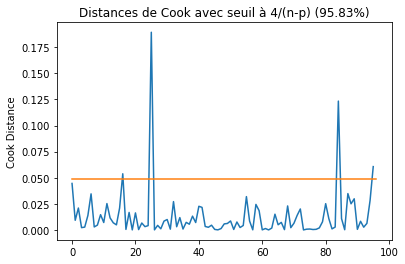

In [18]:
linear_regression_analysis(reg_ols1)

#### Substract DJU coefficient

I get the DJU coefficient, so I can use it to compute the comsumption based on DJU. And I can substract it from the time series.

In [19]:
# Get the coefficient from the linear regression model
coeff = reg_ols1.params['dju']

# Apply the coeff on DJU column and substract the result to the time series
df5["consommation-hf"] = round(df5["consommation"] - (coeff * df5["dju"])).astype(int)

#### Consumption VS adjusted consumption

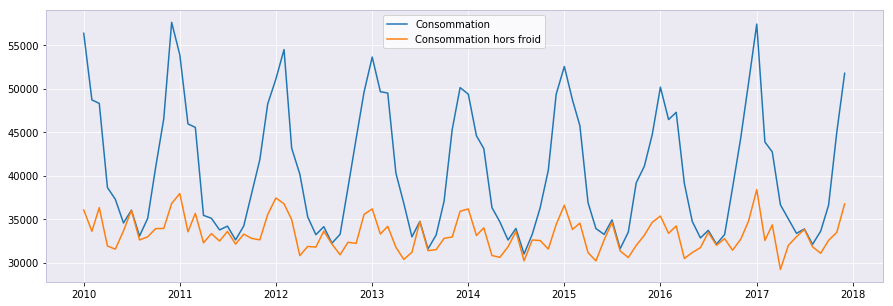

In [20]:
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(df5["consommation"], label="Consommation")
plt.plot(df5["consommation-hf"], label="Consommation hors froid")
MyPlot.bg(ax)
MyPlot.border(ax)
plt.legend()
plt.show()

## 4. Time series correction - Seasonality

To get the seasonality, I use seasonal_decompose from statsmodels.tsa.seasonal which is based on an algorithm using moving averages.

Once I got it, I substract it from the DJU corrected time series.

#### Compute the seasonal decompose

In [21]:
# Seasonal decompose
decomp_x = seasonal_decompose(df5["consommation-hf"],  model='additive')

# Substract the seasonal component
df5['consommation-hf-hs'] = df5['consommation-hf'] - decomp_x.seasonal

#### Plot the results

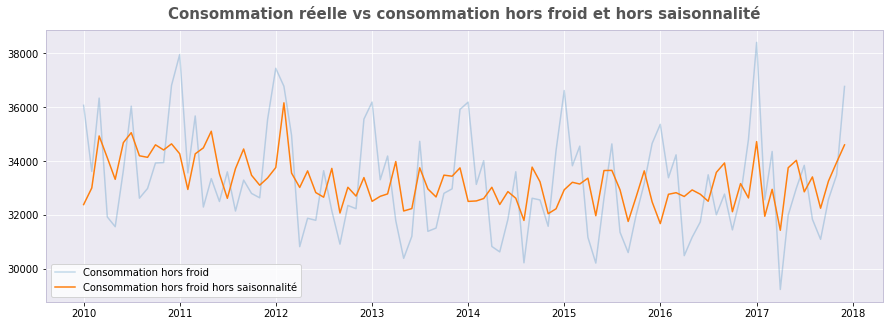

In [22]:
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(df5["consommation-hf"], label="Consommation hors froid", alpha=0.25)
plt.plot(df5["consommation-hf-hs"], label="Consommation hors froid hors saisonnalité")
MyPlot.bg(ax)
MyPlot.border(ax)
plt.legend()
MyPlot.title(ax, "Consommation réelle vs consommation hors froid et hors saisonnalité")
plt.show()

## 5. Time series forecasting with Holt-Winters method (double exponential smoothing)

I use ExponentialSmoothing from statsmodels.tsa.api.

Documentation : https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

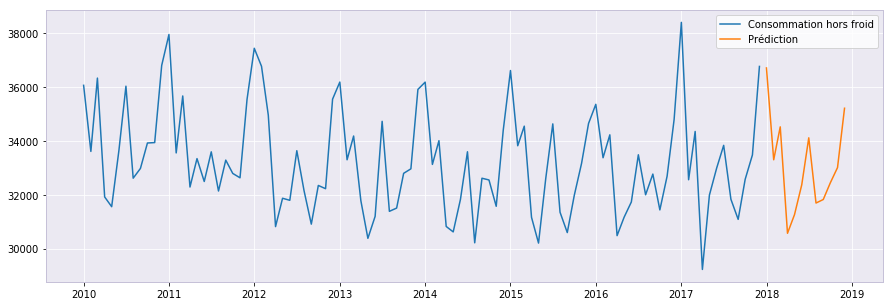

In [23]:
y = np.asarray(df5["consommation-hf"])

hw = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(12)

fig, ax = plt.subplots(figsize=(15,5))
plt.plot(df5['consommation-hf'], label='Consommation hors froid')
plt.plot(pd.date_range(df.index[len(y)-1], periods=12, freq='M'), hw_pred, label='Prédiction')
plt.legend()
MyPlot.bg(ax)
MyPlot.border(ax)
plt.show()

## 6. Time series Forecasting with SARIMA method

Ressources :

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

Autocorrelogram function

In [29]:
df5['consommation-hf'].values

array([36063, 33611, 36331, 31922, 31560, 33649, 36031, 32618, 32979,
       33923, 33939, 36802, 37949, 33555, 35668, 32290, 33344, 32495,
       33595, 32142, 33288, 32794, 32632, 35538, 37437, 36769, 34954,
       30821, 31873, 31797, 33637, 32150, 30913, 32348, 32228, 35551,
       36184, 33301, 34182, 31782, 30386, 31202, 34727, 31388, 31509,
       32798, 32965, 35911, 36181, 33129, 34009, 30827, 30625, 31832,
       33598, 30220, 32616, 32552, 31575, 34393, 36612, 33821, 34548,
       31166, 30210, 32614, 34632, 31355, 30600, 31984, 33164, 34649,
       35358, 33376, 34226, 30486, 31167, 31735, 33486, 32002, 32770,
       31441, 32691, 34795, 38399, 32560, 34351, 29232, 31990, 32992,
       33836, 31834, 31090, 32577, 33480, 36764])

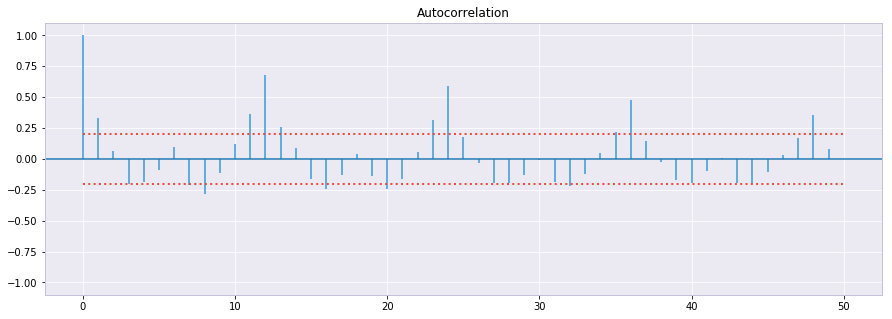

In [24]:
acf(df5['consommation-hf'], 50)

Partial autocorrelogram function

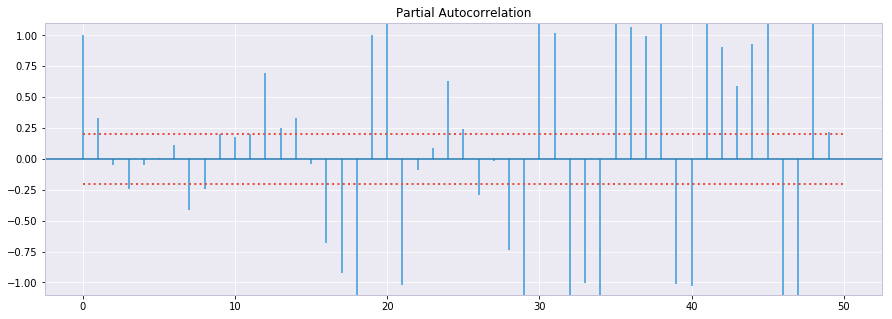

In [27]:
acf(df5['consommation-hf'].values, 50, partial=True)

### Find the best SARIMA model

I wrote an algorithm to select best models which computes RMSE for each model, based on the "one step forcast" method.

Inspired by this one: https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/

Documentation about the differents stats that I use:
    https://www.statsmodels.org/dev/generated/statsmodels.stats.stattools.jarque_bera.html#statsmodels.stats.stattools.jarque_bera
    https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality
    https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation

In [57]:
def sarima_score(train, test, config):
    """ Returns RMSE based on walk-forward validation.
        Args:
            train (Pandas series): train data
            test (Pandas series): test data
            config (tuple): configuration of the model based on (p,d,q)(P,D,Q,m)
    
    """
    
    # Immediately from the first loop, the first element is moved from test to train.
    # So the test list reference has to begin to the 2nd element.
    test_list = list(test)[1:]
    
    # Pred list will be the results to compare to test list
    pred_list = []
    
    # Model configuration
    order, seasonal_order = config
    
    # Main loop
    for i in range(len(test)-1):
        is_error = False
        train.append(test[i])
        try:
            # Create and fit
            model = SARIMAX(
            train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False).fit()
            
            # Forecast one step
            mode_result = model.forecast(1)
            
            # Save the result
            pred_list.append(mode_result)
        
        # Break the loop If an error occurred
        except:
            is_error = True
            break
    
    # Save "infinite" for the root mean squared error if there was an error.
    if is_error:
        return config, np.inf
    
    # Else save the RMSE score plus other important statistics
    else:
        # Get the pvalues for 12 lags. Since H0 means lag is "white", we keep the "worst" one, so min().
        white1 = min(model.test_serial_correlation(method="ljungbox", lags=12)[0][1])
        
        # The same but with the boxpierce method.
        white2 = min(model.test_serial_correlation(method="boxpierce", lags=12)[0][1])
        
        # Gaussian test. H0 is the residues are gaussian.
        gaussian = model.test_normality("jarquebera")[0][1]
        
        # AIC
        aic = model.aic
        
        # Max parameter pvalue. Get the worst parameter pvalue from the available ones.
        pparam = model.pvalues.max()
        
        # RMSE
        rmse = np.sqrt(mean_squared_error(test_list, pred_list))
        
        # Results
        return config, rmse, aic, white1, white2, gaussian, pparam

# Generate sarima configs
def sarima_configs():
    
    configs = []
    ps = [0,1,2]
    ds = [0,1]
    qs = [0,1,2]
    Ps = [0,1,2]
    Ds = [0,1]
    Qs = [0,1,2]
    ms = [12]
    
    for p in ps:
        for d in ds:
            for q in qs:
                for P in Ps:
                    for D in Ds:
                        for Q in Qs:
                            for m in ms:
                                config = ((p,d,q), (P,D,Q,m))
                                configs.append(config)
    return configs

# Main function
def sarima_grid(data, parallel=True):
    
    # Take 20% for the test
    n_test = int(np.ceil(len(data)*20/100))
    
    # Split train / test
    train = list(data[:-n_test])
    test = list(data[-n_test:])

    configs = sarima_configs()
    
    if parallel:
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(sarima_score)(train, test, config) for config in configs)
        rmse = executor(tasks)   
        
    else:
        rmse = [sarima_score(train, test, config) for config in configs]                           
        
    return rmse

# A function to make the matrice looking better, fancier, stronger.
def sarima_df(results):
    df = pd.DataFrame(results)
    df.rename({
        
        0:'config',
        1:'RMSE',
        2:'AIC',
        3:'Ljung-Box',
        4:'Box-Pierce',
        5:'Jarquebera',
        6:'pvalue'},
        
        axis=1,
        inplace=True)
    
    return df

#### Number of analyzed models

In [31]:
len(sarima_configs())

324

#### Run the algorithm

In [55]:
%%time
data = df5["consommation-hf"].values
df_par = sarima_grid(data, parallel=True)

CPU times: user 690 ms, sys: 137 ms, total: 827 ms
Wall time: 15min 22s


#### Best models

In [56]:
df_results = sarima_df(df_par)

# Whiteness, pvalue > 0.05
df_results_filtered = df_results[df_results['Ljung-Box'] > 0.05].copy()
df_results_filtered = df_results_filtered[df_results['Box-Pierce'] > 0.05].copy()

# Gaussian, pvalue > 0.05
df_results_filtered = df_results_filtered[df_results['Jarquebera'] > 0.05].copy()

# Parameter pvalue < 0.05
df_results_filtered = df_results_filtered[df_results['pvalue'] < 0.05].copy()

# Good models, ranged by RMSE
display(df_results_filtered.sort_values(by='RMSE'))

,config,RMSE,AIC,Ljung-Box,Box-Pierce,Jarquebera,pvalue
256,"((2, 0, 2), (0, 1, 1, 12))",1005.184372,1107.401781,0.473321,0.570125,0.649124,4.499125e-05
9,"((0, 0, 0), (1, 1, 0, 12))",1106.185111,1192.163070,0.077319,0.127152,0.061323,7.410470e-06
15,"((0, 0, 0), (2, 1, 0, 12))",1124.475804,978.004114,0.116577,0.199793,0.435218,4.888924e-02
135,"((1, 0, 1), (1, 1, 0, 12))",1151.622155,1175.327071,0.059703,0.101890,0.674031,3.452416e-02
136,"((1, 0, 1), (1, 1, 1, 12))",1166.756530,1139.324095,0.105795,0.164347,0.887819,3.284919e-03
79,"((0, 1, 1), (1, 0, 1, 12))",1178.772083,1345.421893,0.147726,0.221350,0.373774,5.792705e-10
210,"((1, 1, 2), (2, 0, 0, 12))",1195.170407,1149.745710,0.124954,0.181865,0.934578,3.907018e-03
12,"((0, 0, 0), (2, 0, 0, 12))",1204.882415,1190.871080,0.103956,0.142843,0.057914,3.386643e-06
255,"((2, 0, 2), (0, 1, 0, 12))",1205.510413,1346.763888,0.188187,0.196473,0.481560,1.234983e-08
192,"((1, 1, 1), (2, 0, 0, 12))",1281.755907,1165.225407,0.204332,0.250862,0.853285,1.445863e-02


#### The final model

In [30]:
# Initialization
data = df5["consommation-hf"].copy()
order = (2, 0, 2)
seasonal_order = (0, 1, 1, 12)

# Model (thanks to statsmodels)
model = SARIMAX(
    data,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False).fit()

# Summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                    consommation-hf   No. Observations:                   96
Model:             SARIMAX(2, 0, 2)x(0, 1, 1, 12)   Log Likelihood                -559.446
Date:                            Thu, 30 May 2019   AIC                           1130.892
Time:                                    20:14:35   BIC                           1144.297
Sample:                                01-01-2010   HQIC                          1136.210
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7820      0.081      9.679      0.000       0.624       0.940
ar.L2         -0.8889      0.063    -14.080      0.000      -1.013      -0.765
ma.L1         -1.0850      0.178     -6.081      0.000      -1.435      -0.735
ma.L2          0.9858      0.326      3.028      0.002       0.348       1.624
ma.S.L12      -0.5464      0.068     -8.070      0.000      -0.679      -0.414
sigma2      5.312e+05   1.79e+05      2.963      0.003     1.8e+05    8.83e+05
===================================================================================
Ljung-Box (Q):                       32.54   Jarque-Bera (JB):                 0.46
Prob(Q):                              0.79   Prob(JB):                         0.80
Heteroskedasticity (H):               1.06   Skew:                             0.17
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Confidence interval at 95% applied to 20% test data

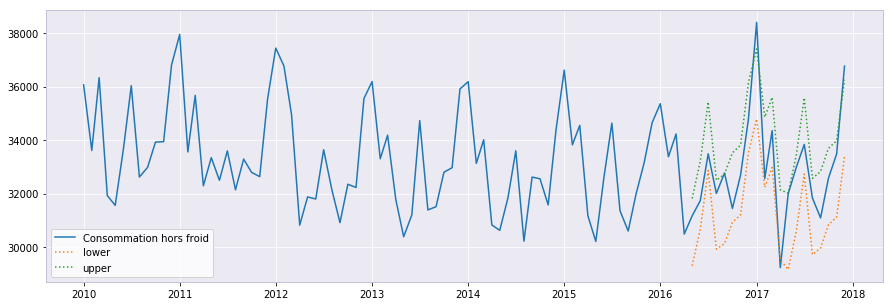

In [31]:
endstart = int(len(data)*80/100)
train = data[:endstart]
test = data[endstart:]
predict_period = 20

model = SARIMAX(
    train.values,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False).fit()

fcast = model.get_forecast(predict_period)

# Mean, low, high (conf. int. 95%)
mean_vals = fcast.predicted_mean
low_vals = []
up_vals = []
for low, up in fcast.conf_int():
    low_vals.append(low)
    up_vals.append(up)

fig, ax = plt.subplots(figsize=(15,5))
plt.plot(data, label='Consommation hors froid')
start=train.index[len(train)-1] + pd.DateOffset(months=1)
#plt.plot(pd.date_range(start, periods=predict_period, freq='MS'), mean_vals, label='mean')

# MS freq takes the first day of the month
plt.plot(pd.date_range(start, periods=predict_period, freq='MS'), low_vals, label='lower', linestyle="dotted")
plt.plot(pd.date_range(start, periods=predict_period, freq='MS'), up_vals, label='upper', linestyle="dotted")
plt.legend()
MyPlot.bg(ax)
MyPlot.border(ax)
plt.show()

## One Year Forecasting

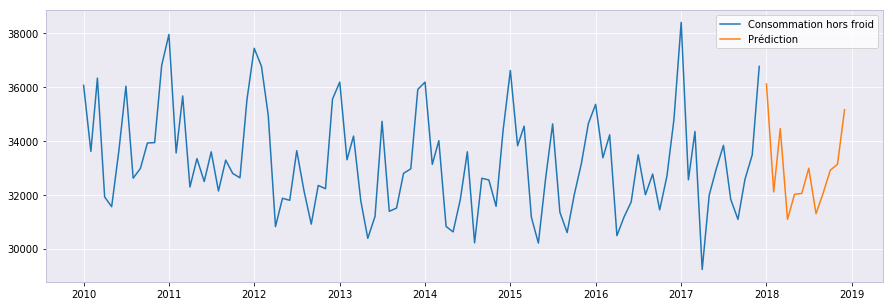

In [32]:
model = SARIMAX(
    data.values,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False).fit()

sarima_pred = model.forecast(12)
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(data, label='Consommation hors froid')
start=data.index[len(data)-1] + pd.DateOffset(months=1)
plt.plot(pd.date_range(start, periods=12, freq='MS'), sarima_pred, label='Prédiction')
plt.legend()
MyPlot.bg(ax)
MyPlot.border(ax)
plt.show()